Import Packages

In [182]:
import pandas as pd #Dataframe manipulation
import numpy as np

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
# from scipy.sparse import hstack


#Feature Selection
from sklearn.feature_selection import SelectKBest

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import GradientBoostingClassifier

#Model Performance Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

Loading data

In [2]:
raw_train_df = pd.read_csv('train_set.csv')
raw_test_df = pd.read_csv('test_set.csv')

### Exploratoy Data Analysis

Functions Declaration

In [3]:
print(raw_train_df.shape)
print(raw_train_df.isna().sum())
raw_train_df['lang_id'].value_counts()

(33000, 2)
lang_id    0
text       0
dtype: int64


xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

Data has:
- No null values
- Equally distributed observations for the predict variables

#### Cleaning data

Feature Engineering

In [12]:
train_df = raw_train_df.copy(deep=True)

To carry out data preparation for the training data, we shall carry out: <br>
- Develop additional features based on the text info
- LabelEncoding of the output variable, y
- Vectorizing the text column texts

### Additional Features 
We can create additional features by considering the characteristics of the individual texts. ie, word count, vowel count et al. <br>
It is not expected that these will play a critical role, given the random form of human communication, but any form of variability would be tracked & exploited.

In [149]:
def add_features(df):
    punc = ('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?")
    vowels=['a','e','i','o','u']

    df['word_count'] = df['text'].apply(lambda x : len(x.split())) #count number of words in each text

    df['char_count'] = df['text'].apply(lambda x : len(x.replace(' ', ''))) # number of characters

    df['word_density'] = df['word_count'] / (df['char_count'] + 1 ) #word density words/characters 

    df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in punc])) # number of punctuations

    df['count_vowels'] = df['text'].apply(lambda x : len([a for a in x if a in vowels])) #number of vowels

    df['vowel_density'] = df['count_vowels'] / df['word_count'] #vowels / words

    df['encode_ascii'] = np.NaN #whether the words lie in the utf-8 alphabet format [a-zA-Z]  

    for i in range(len(df)):
        try:
            df['text'].iloc[i].encode(encoding= 'utf-8').decode('ascii')

        except UnicodeDecodeError:
            df['encode_ascii'].iloc[i] = 0
        
        else:
            df['encode_ascii'].iloc[i] = 1

    #Plot for Correlation
    plt.figure(figsize=(6,6))
    sns.pairplot(df)

    return df



C:\Users\teddy\miniconda3\envs\DS_env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<Figure size 432x432 with 0 Axes>

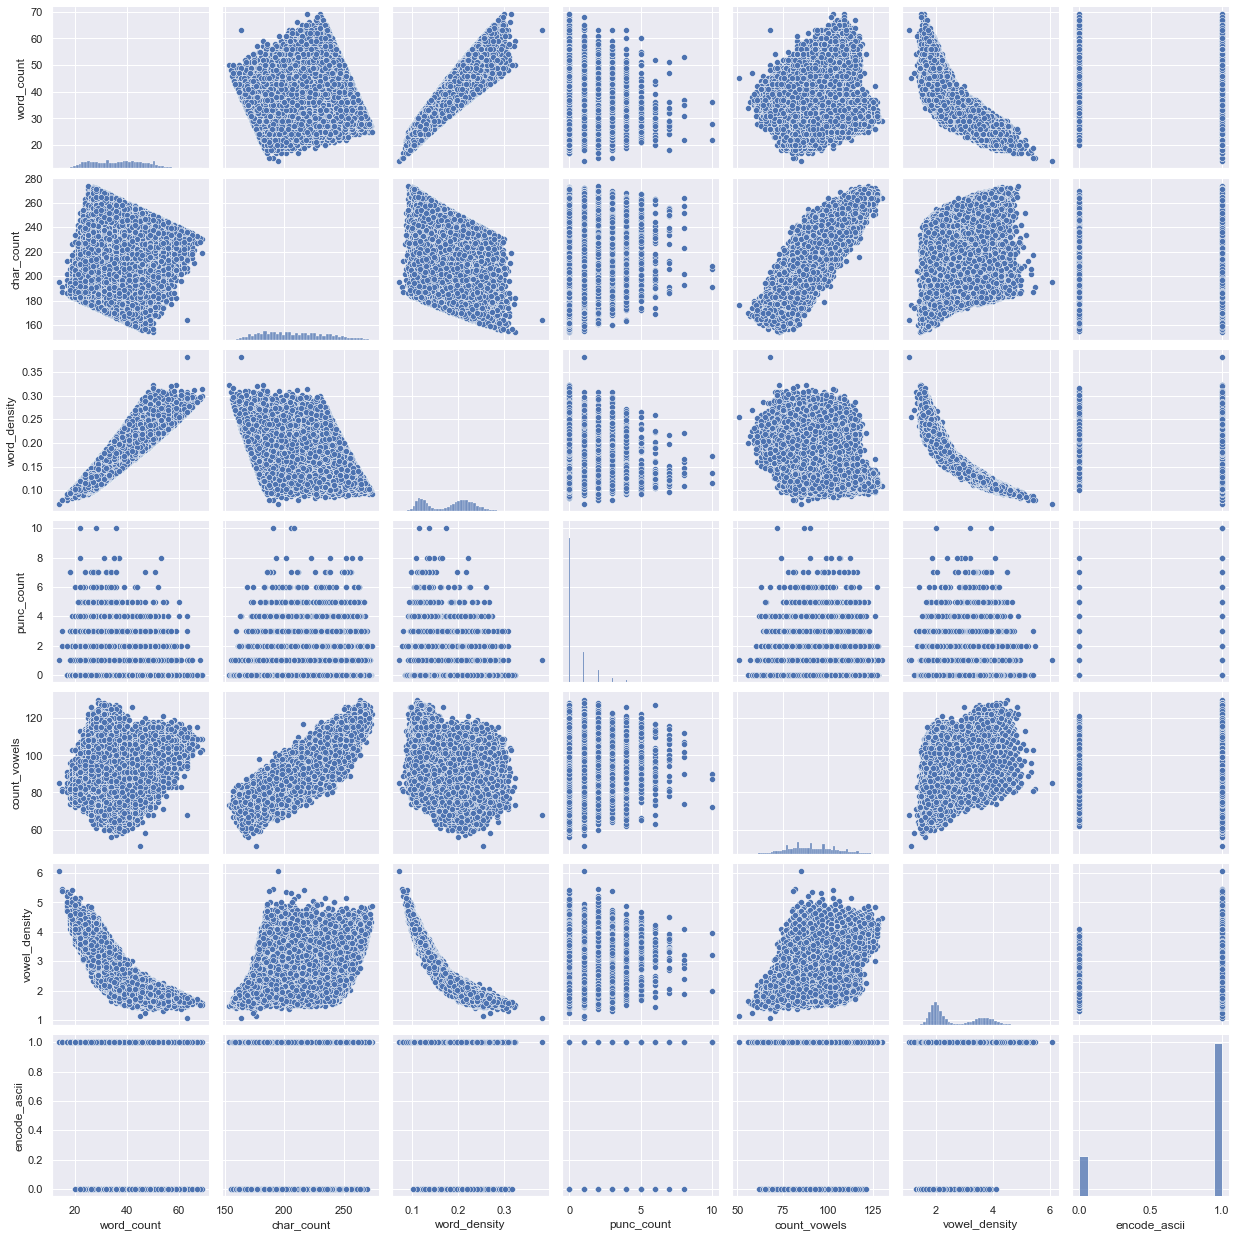

In [150]:
train_df = add_features(train_df)

Some features show correlation based on the above graph. It would be interesting to see which features of this list shall be conidered during feature selection.

Scaling

In [148]:
train_df.groupby('lang_id').mean().T

lang_id,afr,eng,nbl,nso,sot,ssw,tsn,tso,ven,xho,zul
word_count,39.285333,40.233333,25.746000,45.252667,45.734000,26.319000,44.930333,42.775667,44.261333,27.293333,26.595667
char_count,207.641000,206.600667,219.967333,197.764333,201.896333,219.477333,201.834333,202.955333,202.246333,218.889000,217.284333
word_density,0.189002,0.194288,0.116616,0.228022,0.225859,0.119526,0.222014,0.210104,0.218126,0.124324,0.121945
punc_count,0.693000,0.341667,0.722333,0.137667,0.113000,0.565333,0.238000,0.264000,0.177333,0.813667,0.546000
count_vowels,87.793333,79.937667,98.613667,90.527667,89.495333,95.221000,89.172000,90.637333,87.488333,98.787333,97.922667
vowel_density,2.277217,2.011395,3.858009,2.016783,1.970932,3.650710,1.999854,2.133001,1.987664,3.653701,3.713563
encode_ascii,0.647333,0.967667,0.995667,0.014667,0.998000,0.998667,0.764000,0.999333,0.313333,0.997667,0.998000


We can proceed to clean the text data<br>
In this case we shall remove any none alphabetic characters.

In [154]:
train_df['clean_txt'] = train_df['text'].apply(lambda x: re.sub(r'[^a-zA_Z ]', '', x))

In [155]:
train_df['clean_txt']

0        umgaqosiseko wenza amalungiselelo kumaziko axh...
1        idha iya kuba nobulumko bokubeka umsebenzi nap...
2        the province of kwazulunatal department of tra...
3        o netefata gore o ba file dilo ka moka te le d...
4        khomishini ya ndinganyiso ya mbeu yo ewa maana...
                               ...                        
32995    popo ya dipolateforomo tse ke go tlisa boetele...
32996    modise mosadi na o ntse o sa utlwe hore thaban...
32997    closing date for the submission of completed t...
32998    nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999    mafapha a mang le ona a lokela ho etsa ditlale...
Name: clean_txt, Length: 33000, dtype: object

The folowing function intends to labelEncode the predict variable & vectorize the texts. <br>
- Input: training DataFrame, WordVectorizer Class<br>
- Output: X, y, LabelEncoder object, Vectorizer object<br>

In [178]:
def train_preprocessing(df_, vectorizer):
    df = df_.copy(deep= True)

    X = df['text']
    y = df['lang_id']
    z = df[[col for col in df.columns if col not in ['text', 'lang_id']]]

    #Encode predict variable
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Vectorize the X variable(texts)
    X = vectorizer.fit_transform(X)
    print(type(X))
    #Print X variable shape
    # X.join(z, how='left')
    # for column in z:
    #     arr = z[column].values[:,None]
    #     X = hstack((X, arr))
    
    print('Shape of the X Variable: {}'.format(X.shape))

    return X, y, le, vectorizer

In [179]:
X, y, label_encoder, vectorizer = train_preprocessing(train_df, TfidfVectorizer())

<class 'scipy.sparse.csr.csr_matrix'>
Shape of the X Variable: (33000, 141958)


The vectorizer produced 141958 features based on the words in the texts

#### Train Test Split the Dataset

We split the dataset into training & train_testing  bits

In [180]:
X_train, X_test, y_train, y_test =train_test_split(X,y,
                                        test_size=0.2,
                                        random_state=0)

## Modelling

#### Feature Selection

Given that the current X variable has >141,000 features based on the words in the corpus, it's necessary to cut down the words to only the most useful in training the model. <br>
We shall then use the SelectBest class, which selects the best 'k' features that will be used in the modelling later. The 'k' value shall be iterated until the most optimal value is identified.

We declare functions that shall carry out the following:
1. Fit the predictive model using X_train(filtered using SelectKBest), & y_train
2. Transform X_test based on the selectKBest object
3. Carry out predictions for X_test
4. Print out the Classification Report.
5. Plot the resultant confusion matrix

In [181]:
select_k_best = SelectKBest(k= 60000)

In [197]:
def select_features(X_train, X_test):
    # y_train & y_test are globally declared
    filter_X_train = select_k_best.fit_transform(X_train,y_train)
    filter_X_train.shape

    #Transform our X_test based on the SelectKBest feature selection object
    filter_X_test = select_k_best.transform(X_test)

    return filter_X_train, filter_X_test

In [209]:
def fit_eval_model(pred_model, X_train, X_test):
    
    # fit the pred_model
    pred_model.fit(X_train, y_train)

    # Predict values for Test dataset
    y_pred = pred_model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = train_df['lang_id'].unique()
    # group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}' for v1 in group_percentages]
    labels = np.asarray(labels).reshape(11,11)
    # labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    # labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(15,8))
    sns.heatmap(cf_matrix,
                annot = labels,
                cmap = 'Blues',fmt = '',
                xticklabels = categories,
                yticklabels = categories,)

    # return pred_model

#### Multinomial Bernoulli Classification

The Multinomial Bernoulli Classification was selected here due to:
- Implementation of other models could not yield better results after hyper-tuning: the RandomForestClassifier & XGBoost Classifier, & also the loading time was too long for these models, given the number of features that are being utilized.
- MultiNomial Bernoulli Classification is suitable for the problem statement, since it works well with word count data, which was obtained from the Vectorization process achieved by the TFIdfVectorizer.
> Additional models are included below, but comparisons are not done.

C:\Users\teddy\miniconda3\envs\DS_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\teddy\miniconda3\envs\DS_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       587
           1       0.99      1.00      1.00       574
           2       1.00      1.00      1.00       613
           3       1.00      1.00      1.00       570
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       624
           6       1.00      1.00      1.00       581
           7       1.00      1.00      1.00       597
           8       1.00      1.00      1.00       599
           9       1.00      1.00      1.00       621
          10       1.00      1.00      1.00       634

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



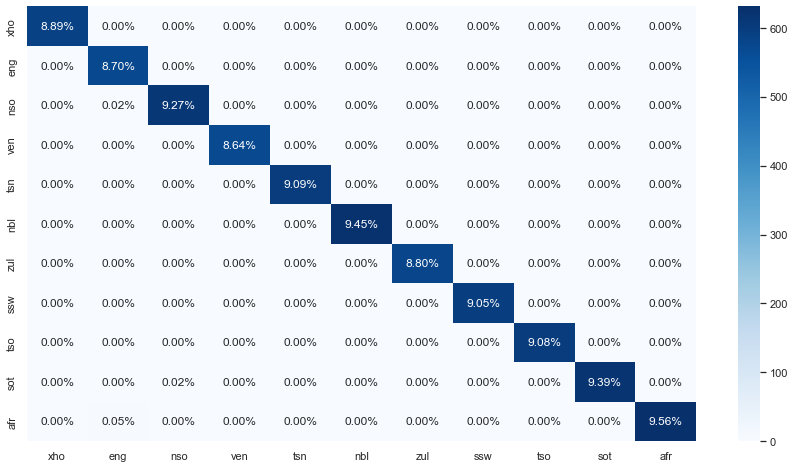

In [210]:
mnb = MultinomialNB()


mnb_X_train, mnb_X_test = select_features(X_train,X_test)

fit_eval_model(mnb, X_train, X_test)

The model shows a high accuracy based on the classification report. The confusion matrix shows which languages may bring the model's performance down. Ideally, the main diagonal should have values of 9.09% to signify that each language is being classified accurately.

### RandomForest Classifier

C:\Users\teddy\miniconda3\envs\DS_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\teddy\miniconda3\envs\DS_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       587
           1       0.99      1.00      0.99       574
           2       0.83      0.92      0.87       613
           3       1.00      0.99      0.99       570
           4       1.00      1.00      1.00       600
           5       0.96      0.89      0.92       624
           6       0.99      1.00      0.99       581
           7       0.99      1.00      1.00       597
           8       1.00      1.00      1.00       599
           9       0.94      0.94      0.94       621
          10       0.89      0.84      0.87       634

    accuracy                           0.96      6600
   macro avg       0.96      0.96      0.96      6600
weighted avg       0.96      0.96      0.96      6600



GridSearchCV(error_score=0, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 15, 20],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='f1_weighted')

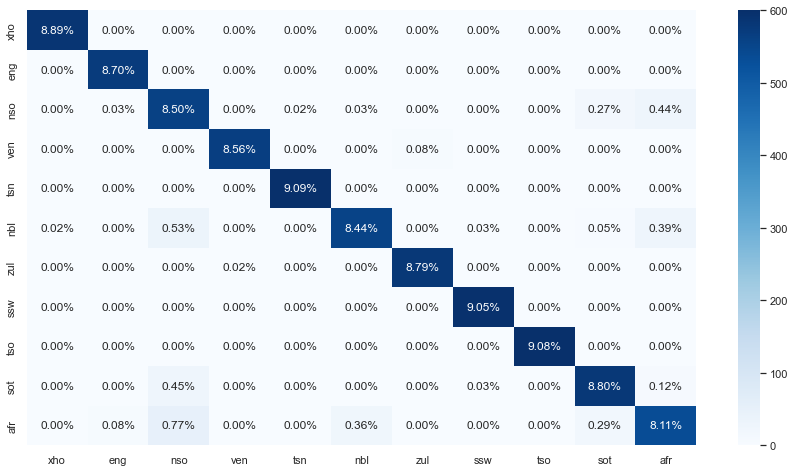

In [202]:
parameters = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [8, 15, 20] 
}

rfc = RandomForestClassifier()

rfc_grid_search = GridSearchCV(
                        estimator= rfc,
                        param_grid = parameters,
                        scoring = 'f1_weighted',
                        error_score= 0
                    )

rfc_X_train, rfc_X_test = select_features(X_train, X_test)

fit_eval_model(rfc_grid_search, select_k_best, rfc_X_train, rfc_X_test)

The table below shows the results of the GridSearch for the parameter grid that was supplied.

In [193]:
rfc_results = pd.DataFrame.from_dict(rfc_grid_search.cv_results_)
rfc_results.sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,26.219559,2.723977,0.509240,0.155291,20,200,"{'max_depth': 20, 'n_estimators': 200}",0.962335,0.960491,0.964608,0.957990,0.954187,0.959922,0.003598,1
7,19.245526,1.295075,0.384781,0.138491,15,200,"{'max_depth': 15, 'n_estimators': 200}",0.957103,0.949582,0.962688,0.955952,0.954106,0.955886,0.004258,2
10,11.394020,1.546344,0.277405,0.024997,20,100,"{'max_depth': 20, 'n_estimators': 100}",0.955914,0.952303,0.957826,0.954351,0.950283,0.954136,0.002647,3


Test Score for the best performant(max_depth=20 & n_estimators=200) was ~0.96 with  & a significantly high fitting time

#### Gradient Boosting Classifier

In [211]:
# gbc = GradientBoostingClassifier(n_estimators= 20, learning_rate=0.5)

# fit_eval_model(gbc, X_train, X_test)

parameters = {
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.25, 0.5, 1] 
}

gbc = GradientBoostingClassifier()

gbc_grid_search = GridSearchCV(
                        estimator= gbc,
                        param_grid = parameters,
                        scoring = 'f1_weighted',
                        error_score= 0
                    )

gbc_X_train, gbc_X_test = select_features(X_train, X_test)

fit_eval_model(gbc_grid_search, gbc_X_train, gbc_X_test)

C:\Users\teddy\miniconda3\envs\DS_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\teddy\miniconda3\envs\DS_env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Predictions

We need to preprocess the predict data through similar steps as the training data:
1. Vectorizing the texts
2. Filtering the features based on the select_k_best object

In [204]:
def test_preprocessing(df_, select_k_best, vectorizer):

    df = df_.copy(deep=True)

    test_X = vectorizer.transform(df['text'])

    test_X = select_k_best.transform(test_X)


    return test_X

The following function takes in a model & intended output .csv file. It intends to carry out the prediction based on the model utilized.

In [136]:
def pred_test(model, filename):
    test_X = test_preprocessing(raw_test_df, select_k_best, vectorizer)
    pred = model.predict(test_X)
    lang_id = le.inverse_transform(pred)

    sub_pred = pd.DataFrame(
        {
            'index': range(1, len(lang_id) + 1),
            'lang_id':   lang_id
        }
    )

    sub_pred.to_csv(filename, index = False)
    return sub_pred



In [142]:
sub_pred = pred_test(mnb,'220401-mnb_sub_1.csv')       #Predict & create a submission file based on the MultiNomialBernoulli model
sns.countplot(sub_pred['lang_id'])                      # Visualize the distribution of the distributions